In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.metrics import jaccard_score
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples


In [174]:
questions_programming1 = pd.read_csv('Programming1.2.csv')
skills = pd.read_csv('Skills1.3.csv')
student_answers_programming1 = pd.read_csv('StudentAnswers.csv')

In [175]:

questions_programming1.columns = questions_programming1.iloc[0] 
questions_programming1 = questions_programming1.drop(questions_programming1.index[0])  


questions_programming1.columns = ['Question Number', 'Option', 'Statement I', 'Statement II', 'Statement III', 'Statement IV', 'Skills Demonstrated', 'Skills Lacking', 'Additional Info']


questions_programming1['Question Number'] = pd.to_numeric(questions_programming1['Question Number'], errors='coerce')


print(questions_programming1.head())
print(skills.head())
print(questions_programming1['Question Number'].dtype)

   Question Number Option Statement I Statement II Statement III Statement IV  \
1                1      A           0            1             0            1   
2                1      B           0            0             1            1   
3                1      C           1            0             0            1   
4                1      D           0            1             1            0   
5                1      E           0            0             0            0   

  Skills Demonstrated Skills Lacking Additional Info  
1                   1            2;4             NaN  
2               1;2;4            NaN             NaN  
3                   1            2;4             NaN  
4                   2            1;4             NaN  
5                 NaN          1;2;4             NaN  
   Code     Skill/Error Sub skill  Sum
0     1  initialisation       int    2
1     2  initialisation    string    2
2     3  initialisation     float    1
3     4   concatenation    

In [176]:
questions_programming1.columns = [
    'Question Number', 
    'Option', 
    'Statement I', 
    'Statement II', 
    'Statement III', 
    'Statement IV', 
    'Skills Demonstrated', 
    'Skills Lacking',
    'Available'
]
questions_programming1.fillna('', inplace=True)

In [177]:
skills.fillna('Not specified', inplace=True)

In [178]:
student_answers_programming1.set_index('Student:', inplace=True)

In [179]:
def map_skills(question_number, student_answer, questionss):

    question_row = questionss[questionss['Question Number'] == question_number]
    
    if question_row.empty:
        print(f"No data found for question number {question_number}")
        return [], []
    
    answer_row = question_row[question_row['Option'] == student_answer]
    
    if answer_row.empty:
        print(f"No matching option found for question {question_number} and answer {student_answer}")
        return [], []

    skills_demonstrated = answer_row['Skills Demonstrated'].values[0] if not answer_row.empty else ''
    skills_lacking = answer_row['Skills Lacking'].values[0] if not answer_row.empty else ''
    

    demonstrated_skills_info = skills[skills['Code'].isin([int(x) for x in skills_demonstrated.split(';') if x])]
    lacking_skills_info = skills[skills['Code'].isin([int(x) for x in skills_lacking.split(';') if x])]
    
    demonstrated_skills_names = demonstrated_skills_info.apply(lambda row: f"{row['Skill/Error']} ({row['Sub skill']})", axis=1).tolist() if skills_demonstrated else []
    lacking_skills_names = lacking_skills_info.apply(lambda row: f"{row['Skill/Error']} ({row['Sub skill']})", axis=1).tolist() if skills_lacking else []
    
    return demonstrated_skills_names, lacking_skills_names

In [180]:
print(skills.columns)

Index(['Code', 'Skill/Error', 'Sub skill', 'Sum'], dtype='object')


In [181]:
student_skills_programming1 = {}
valid_question_numbers = questions_programming1['Question Number'].unique()

for student_id, answers in student_answers_programming1.iterrows():
    demonstrated_skills = {}
    lacking_skills = {}
    

    for question_num in valid_question_numbers:
        answer = answers[str(question_num)] if str(question_num) in answers else None
        
        if answer is None:
            continue
        
        demo_skills, lack_skills = map_skills(question_num, answer, questions_programming1)
        
        for skill in demo_skills:
            if skill in demonstrated_skills:
                demonstrated_skills[skill] += 1
            else:
                demonstrated_skills[skill] = 1
                
        for skill in lack_skills:
            if skill in lacking_skills:
                lacking_skills[skill] += 1
            else:
                lacking_skills[skill] = 1
    

    student_skills_programming1[student_id] = {
        'Demonstrated Skills': demonstrated_skills,
        'Lacking Skills': lacking_skills
    }
    
unique_skills = set()
for skills_dict in student_skills_programming1.values():
    unique_skills.update(skills_dict['Demonstrated Skills'].keys())
    unique_skills.update(skills_dict['Lacking Skills'].keys())

unique_skills = sorted(unique_skills)

encoded_skills = {skill: [] for skill in unique_skills}


for student_id, skills_dict in student_skills_programming1.items():
    demonstrated = skills_dict['Demonstrated Skills']
    lacking = skills_dict['Lacking Skills']
    
    for skill in unique_skills:
        skill_count = demonstrated.get(skill, 0) - lacking.get(skill, 0)
        
        skill_error, sub_skill = skill.rsplit(' (', 1)
        sub_skill = sub_skill.rstrip(')')

        skill_code = skills[(skills['Skill/Error'] == skill_error) & (skills['Sub skill'] == sub_skill)]['Code'].values[0]
        skill_sum = skills[skills['Code'] == skill_code]['Sum'].values[0]
        
        adjusted_skill_count = skill_count / skill_sum
        
        
        encoded_skills[skill].append(adjusted_skill_count)

skills_df = pd.DataFrame(encoded_skills, index=student_skills_programming1.keys())

skills_df.fillna(0, inplace=True)

print(skills_df.head())

No matching option found for question 11 and answer 0
No matching option found for question 8 and answer 0
No matching option found for question 9 and answer 0
   boolean  (and)  boolean (==')  boolean (binding operatios)  boolean (not)  \
1             0.0            1.0                          0.0      -0.333333   
2             0.0            1.0                          0.0       0.333333   
3             1.0            1.0                          1.0       1.000000   
4             1.0            1.0                          1.0       1.000000   
5             1.0            1.0                          1.0       1.000000   

   boolean (or)  concatenation (string)  definining (arguments)  \
1           0.0                    -1.0                     1.0   
2           1.0                     1.0                     1.0   
3           1.0                     1.0                    -1.0   
4           1.0                     1.0                     1.0   
5           1.0         

In [182]:
temp = np.array(skills_df, dtype='float')

In [183]:
skills_embedded_programming1 = TSNE(n_components=2,init='random', perplexity=20).fit_transform(np.array(skills_df, dtype='float'))

In [184]:
pca = PCA(n_components=17)
skills_reduced = pca.fit_transform(skills_df)

skills_reduced_programming1 = pd.DataFrame(skills_reduced, columns=[f'PC{i+1}' for i in range(17)], index=skills_df.index)
pca_components = pca.components_

In [185]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=0)

kmeans.fit(skills_reduced_programming1)

skills_reduced_programming1['Cluster'] = kmeans.labels_

In [186]:
skills_reduced_programming1['Cluster'].values

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1])

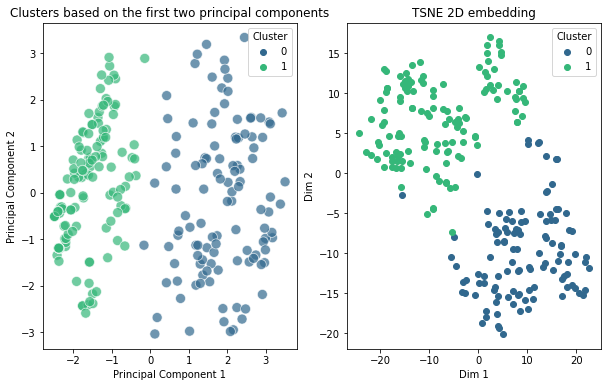

In [187]:
skills_embedded_programming1 = TSNE(n_components=2,init='random', perplexity=20).fit_transform(np.array(skills_df, dtype='float'))

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
sns.scatterplot(data=skills_reduced_programming1, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters based on the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')


plt.subplot(1,2,2)


for n_clus in range(n_clusters):
    idx = np.where(skills_reduced_programming1['Cluster'].values==n_clus)[0]
    plt.scatter(skills_embedded_programming1[idx,0],skills_embedded_programming1[idx,1], color=sns.color_palette('viridis', n_clusters)[n_clus])

plt.title('TSNE 2D embedding')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend([str(i) for i in range(n_clusters)],title='Cluster')
plt.savefig('clusters_programming1.4.png', dpi=300)
plt.show()

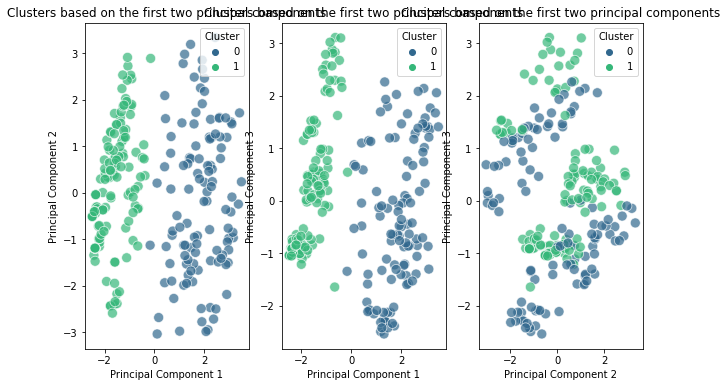

In [188]:
plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)

sns.scatterplot(data=skills_reduced_programming1, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters based on the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')

plt.subplot(1,3,2)
sns.scatterplot(data=skills_reduced_programming1, x='PC1', y='PC3', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters based on the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.legend(title='Cluster')

plt.subplot(1,3,3)
sns.scatterplot(data=skills_reduced_programming1, x='PC2', y='PC3', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters based on the first two principal components')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.legend(title='Cluster')
plt.show()

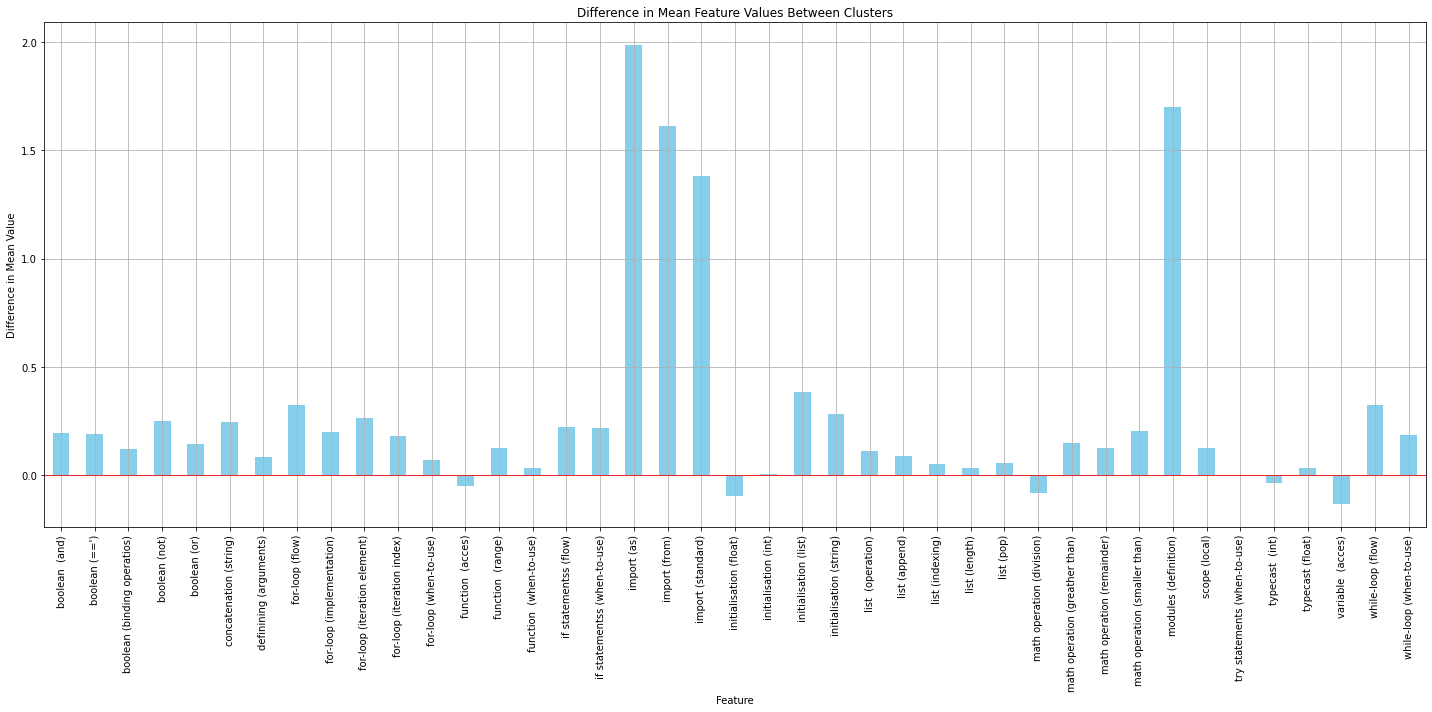

In [189]:
skills_df['Cluster'] = kmeans.labels_


cluster_means = skills_df.groupby('Cluster').mean()


cluster_diff = cluster_means.diff().iloc[-1]


plt.figure(figsize=(20, 10)) 
cluster_diff.plot(kind='bar', color='skyblue')  
plt.title('Difference in Mean Feature Values Between Clusters')
plt.xlabel('Feature')
plt.ylabel('Difference in Mean Value')
plt.axhline(0, color='red', linewidth=0.8)
plt.grid(True)
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.savefig('mean_clusters1.4.png', dpi=300, bbox_inches='tight')  
plt.show()

In [190]:
def get_top_n_features(component, feature_names, n=3):
    abs_component = np.abs(component)
    top_n_indices = abs_component.argsort()[-n:][::-1]
    top_n_features = [(feature_names[i], component[i]) for i in top_n_indices]
    return top_n_features

feature_names = skills_df.columns

top_features_pc1 = get_top_n_features(pca_components[0], feature_names, n=5)
top_features_pc2 = get_top_n_features(pca_components[1], feature_names, n=5)
top_features_pc3 = get_top_n_features(pca_components[2], feature_names, n=5)

print("Top features for PC1:", top_features_pc1)
print("Top features for PC2:", top_features_pc2)
print("Top features for PC3:", top_features_pc3)





Top features for PC1: [('import (as)', -0.49148366400144794), ('import (from)', -0.45219738143649446), ('modules (definition)', -0.4304801686826183), ('import (standard)', -0.39530317492698935), ('for-loop (iteration element)', -0.1787683535026653)]
Top features for PC2: [('for-loop (iteration element)', -0.4441797444619359), ('for-loop (iteration index)', -0.3918940951513565), ('initialisation (list)', -0.3330918045730247), ('for-loop (flow)', 0.3101824753790512), ('while-loop (flow)', 0.310182475379051)]
Top features for PC3: [('for-loop (flow)', -0.5452319358950817), ('while-loop (flow)', -0.5452319358950812), ('for-loop (iteration element)', -0.34201037087352626), ('for-loop (iteration index)', -0.2770916891070101), ('import (from)', 0.20183816085079168)]


Features for Principal Component 1: ('import (as)', 'import (from)', 'modules (definition)', 'import (standard)', 'for-loop (iteration element)')
Weights for Principal Component 1: (-0.49148366400144794, -0.45219738143649446, -0.4304801686826183, -0.39530317492698935, -0.1787683535026653)


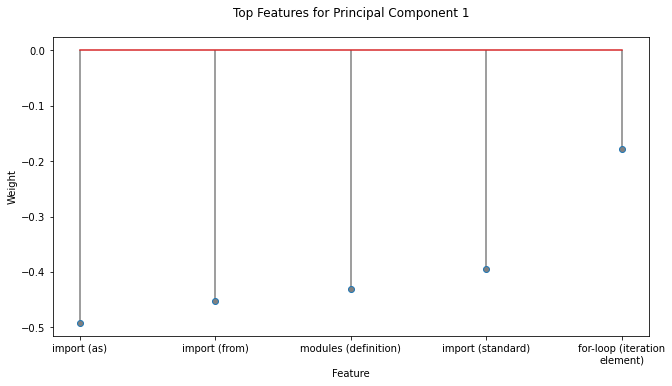

In [191]:
def plot_top_features(top_features, pc_name):
   
    def split_long_name(name, max_length=20):
        words = name.split()
        new_name = ''
        current_line = ''
        for word in words:
            if len(current_line) + len(word) + 1 > max_length:
                new_name += current_line + '\n'
                current_line = word
            else:
                if current_line:
                    current_line += ' '
                current_line += word
        new_name += current_line
        return new_name

    features, weights = zip(*top_features)
    print(f"Features for {pc_name}: {features}")
    print(f"Weights for {pc_name}: {weights}")
    
  
    split_features = [split_long_name(f) for f in features]
    
    indices = np.arange(len(weights))  

    plt.figure(figsize=(10, 6))  
    
 
    markerline, stemlines, baseline = plt.stem(indices, weights, use_line_collection=True)
    plt.setp(markerline, 'markerfacecolor', 'gray')
    plt.setp(stemlines, 'color', 'gray')
    
    plt.xticks(indices, split_features)  
    
    plt.title(f'Top Features for {pc_name}', pad=20)  
    plt.ylabel('Weight')
    plt.xlabel('Feature')
    
 
    plt.tight_layout(pad=3.0)
    
    
    plt.savefig('top_features_programming1_component_1.png', dpi=300)
    plt.show()
plot_top_features(top_features_pc1, 'Principal Component 1')


C:\Users\31611\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


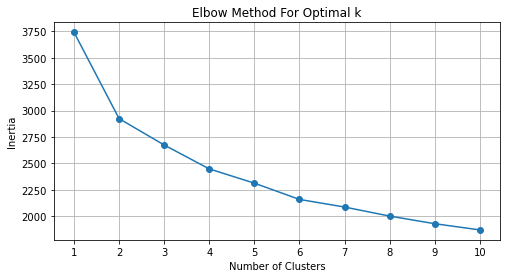

In [192]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


pca = PCA(n_components=15)
skills_reduced = pca.fit_transform(skills_df)


range_clusters = range(1, 11)  
inertias = []

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(skills_reduced)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(8, 4))
plt.plot(range_clusters, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

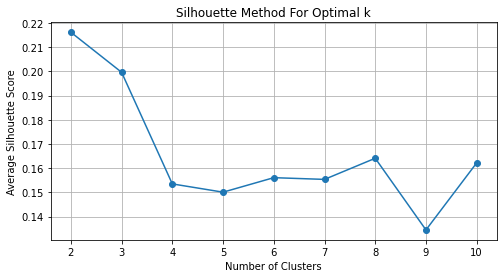

In [193]:
range_clusters = range(2, 11) 
silhouette_scores = []


for n_clusters in range_clusters:

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(skills_reduced)

    silhouette_avg = silhouette_score(skills_reduced, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)


plt.figure(figsize=(8, 4))
plt.plot(range_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.xticks(range_clusters)
plt.grid(True)
plt.savefig('silhouette_programming1.4.png', dpi=300)
plt.show()


In [194]:
optimal_k = 3  

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=None)

for train, test in kf.split(skills_df):
    skills_df_train = skills_df.iloc[train]
    skills_df_test = skills_df.iloc[test]


    pca = PCA(n_components=15)
    skills_reduced_train = pca.fit_transform(skills_df_train)
    skills_reduced_test = pca.transform(skills_df_test)


    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    kmeans.fit(skills_reduced_train)

    test_clusters = kmeans.predict(skills_reduced_test)
    print(f"Assigned clusters for test data: {test_clusters}")

Assigned clusters for test data: [1 2 1 1 1 1 0 0 1 1 0 1 0 2 0 2 1 1 2 2 1 2 2 1 1 1 0 1 0 1 2 0 1 0 0 1 1
 1 1 1 0 1 1 1 0 2 1 2 1]
Assigned clusters for test data: [0 1 1 2 1 2 0 1 0 2 1 2 1 1 2 2 1 1 1 1 0 1 1 2 2 0 2 1 1 2 2 1 1 2 1 1 1
 1 1 1 1 2 1 0 2 0 1 1 1]
Assigned clusters for test data: [1 1 0 1 1 1 1 0 1 2 0 0 0 2 0 1 1 2 2 0 1 2 1 1 1 2 2 1 1 2 0 0 1 1 2 1 1
 1 1 1 1 2 2 1 0 1 0 2 2]
Assigned clusters for test data: [0 2 1 1 2 2 1 1 1 0 1 0 1 1 2 1 1 1 0 2 0 1 1 1 2 0 1 1 1 2 1 2 2 1 1 1 0
 1 2 2 2 1 1 0 1 2 2 2 1]
Assigned clusters for test data: [1 0 1 1 1 2 2 1 1 0 2 0 2 1 0 2 2 0 0 2 1 0 2 0 1 1 1 2 1 1 0 1 1 2 1 1 1
 2 1 1 0 2 1 2 1 1 1 1]


In [195]:
skills_df_test.shape

(48, 42)

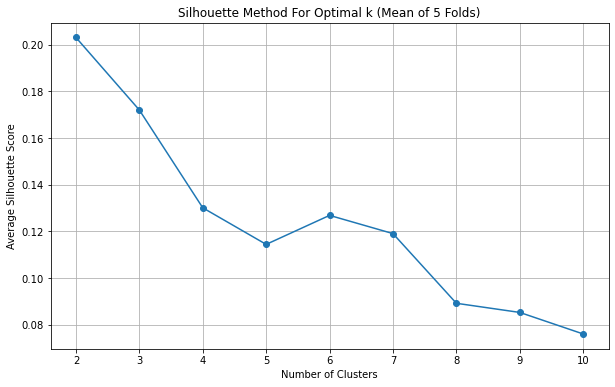

In [196]:
range_clusters = range(2, 11)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=None)


mean_silhouette_scores = []

for n_clusters in range_clusters:
    silhouette_scores = []
    
    for train, test in kf.split(skills_df):
        pca_traintest = PCA(n_components=28)
        
        skills_df_train = skills_df.iloc[train, :]
        skills_df_test = skills_df.iloc[test, :]
        skills_reduced_train = pca_traintest.fit_transform(skills_df_train)
        skills_reduced_test = pca_traintest.transform(skills_df_test)

        kmeans_traintest = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans_traintest.fit(skills_reduced_train)

        cluster_labels = kmeans_traintest.predict(skills_reduced_test)
        

        score = silhouette_score(skills_reduced_test, cluster_labels)
        silhouette_scores.append(score)
    

    mean_silhouette_scores.append(sum(silhouette_scores) / len(silhouette_scores))


plt.figure(figsize=(10, 6))
plt.plot(range_clusters, mean_silhouette_scores, marker='o')
plt.title('Silhouette Method For Optimal k (Mean of 5 Folds)')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.xticks(range_clusters)
plt.grid(True)
plt.savefig('silhouette_programming1.4.png', dpi=300)
plt.show()

In [197]:
k=5
kf = model_selection.KFold(n_splits=k, shuffle=True, random_state=None)

for train, test in kf.split(skills_df):

    pca_traintest = PCA(n_components=17)
    
    skills_df_train = skills_df.iloc[train,:]
    skills_df_test = skills_df.iloc[test,:]
    skills_reduced_train = pca_traintest.fit_transform(skills_df_train)
    skills_reduced_test = pca_traintest.transform(skills_df_test)



    skills_reduced_train_df = pd.DataFrame(skills_reduced_train, columns=[f'PC{i+1}' for i in range(17)], index=skills_df_train.index)
    kmeans_traintest = KMeans(n_clusters=2, random_state=0)
    kmeans_traintest.fit(skills_reduced_train_df)
    print(kmeans_traintest.predict(skills_reduced_test))
    print()


    skills_reduced_train_df['Cluster'] = kmeans_traintest.labels_

[1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 1]

[1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 1 0 1 1]

[1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 0 0 0 1 1 1]

[0 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1
 0 1 1 0 0 0 0 0 1 0 0 0]

[1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1
 1 1 1 0 1 1 0 1 1 0 1]



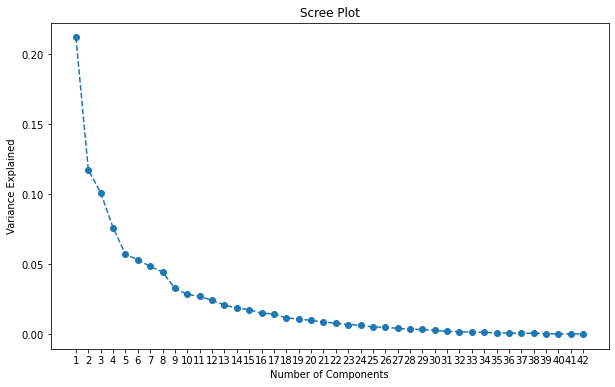

In [198]:
pca = PCA()
pca.fit(skills_df)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

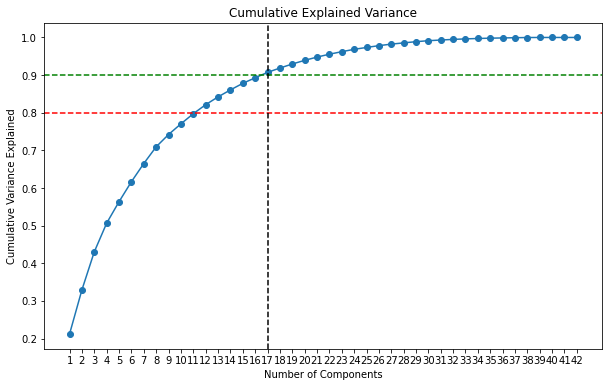

In [199]:
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.axhline(y=0.8, color='r', linestyle='--')  
plt.axhline(y=0.9, color='g', linestyle='--') 

n_comp = np.where(cumulative_explained_variance>0.9)[0][0]+1
plt.axvline(x=n_comp, color='k', linestyle='--')  
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.savefig('cev_programming1.4.png', dpi=200)
plt.show()

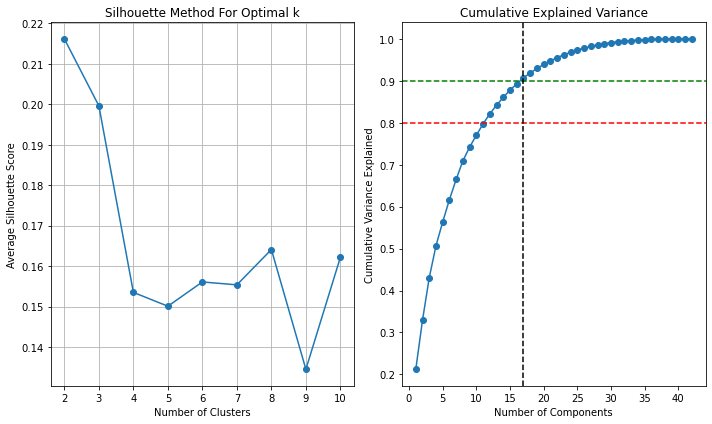

In [200]:
range_clusters = range(2, 11)  
silhouette_scores = []

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(skills_reduced)
    silhouette_avg = silhouette_score(skills_reduced, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)


cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))


ax1.plot(range_clusters, silhouette_scores, marker='o')
ax1.set_title('Silhouette Method For Optimal k')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Average Silhouette Score')
ax1.set_xticks(range_clusters)
ax1.grid(True)


ax2.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
ax2.set_title('Cumulative Explained Variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.axhline(y=0.8, color='r', linestyle='--') 
ax2.axhline(y=0.9, color='g', linestyle='--') 
n_comp = np.where(cumulative_explained_variance > 0.9)[0][0] + 1
ax2.axvline(x=n_comp, color='k', linestyle='--')  
ax2.set_xticks(range(0, len(pca.explained_variance_ratio_) + 1, 5))

plt.tight_layout()
plt.savefig('combined_plot.png', dpi=300)
plt.show()

In [201]:
#programming 2

In [202]:
questions_programming2 = pd.read_csv('Programming2.1.csv')
skills = pd.read_csv('Skills2.3.csv')
student_answers_programming2 = pd.read_csv('StudentAnswers5.csv')

In [203]:
questions_programming2.columns = questions_programming2.iloc[0] 
questions_programming2 = questions_programming2.drop(questions_programming2.index[0]) 

questions_programming2.columns = ['Question Number', 'Option', 'Statement I', 'Statement II', 'Statement III', 'Statement IV', 'Skills Demonstrated', 'Skills Lacking']

questions_programming2['Question Number'] = pd.to_numeric(questions_programming2['Question Number'], errors='coerce')

print(questions_programming2.head())
print(skills.head())
print(questions_programming2['Question Number'].dtype)

   Question Number Option Statement I Statement II Statement III Statement IV  \
1                1      A           1            0             0            0   
2                1      B           0            1             0            0   
3                2      A           1            0             0            0   
4                2      B           0            1             0            0   
5                3      A           1            0             0            0   

  Skills Demonstrated Skills Lacking  
1                 NaN        50;2;21  
2             50;2;21            NaN  
3                 NaN     50;51;1;21  
4          50;51;1;21            NaN  
5                 NaN        52;3;24  
   Code     Skill/Error Sub skill  Sum
0     1  initialisation       int    3
1     2  initialisation    string    4
2     3  initialisation     float    4
3     4   concatenation    string    1
4     5  math operation  division    3
int64


In [204]:
questions_programming2.columns = [
    'Question Number', 
    'Option', 
    'Statement I', 
    'Statement II', 
    'Statement III', 
    'Statement IV', 
    'Skills Demonstrated', 
    'Skills Lacking',
]
questions_programming2.fillna('', inplace=True)

In [205]:
student_answers_programming2.set_index('Student:', inplace=True)

In [206]:
print(skills.columns)

Index(['Code', 'Skill/Error', 'Sub skill', 'Sum'], dtype='object')


In [207]:

def get_skill_code(skill_name, skills_df):
    base_skill_name = skill_name.split(' (')[0]
    if base_skill_name in skills_df['Skill/Error'].values:
        skill_code = skills_df[skills_df['Skill/Error'] == base_skill_name]['Code'].values[0]
        return skill_code
    else:
        print(f"Skill '{base_skill_name}' not found in skills DataFrame.")
        return None

valid_question_numbers = questions_programming2['Question Number'].unique()

skill_counts = {}
for _, row in questions_programming2.iterrows():
    skills_demonstrated = row['Skills Demonstrated'].split(';')
    skills_lacking = row['Skills Lacking'].split(';')
    for skill_code in skills_demonstrated + skills_lacking:
        if skill_code:
            skill_code = int(skill_code)
            if skill_code in skill_counts:
                skill_counts[skill_code] += 1
            else:
                skill_counts[skill_code] = 1

student_skills_programming2 = {}
for student_id, answers in student_answers_programming2.iterrows():
    demonstrated_skills = {}
    lacking_skills = {}
    for question_num in valid_question_numbers:
        answer = answers[str(question_num)] if str(question_num) in answers else None
        if answer is None:
            continue
        demo_skills, lack_skills = map_skills(question_num, answer, questions_programming2)
        for skill in demo_skills:
            demonstrated_skills[skill] = demonstrated_skills.get(skill, 0) + 1
        for skill in lack_skills:
            lacking_skills[skill] = lacking_skills.get(skill, 0) + 1
    student_skills_programming2[student_id] = {
        'Demonstrated Skills': demonstrated_skills,
        'Lacking Skills': lacking_skills
    }

unique_skills = set()
for skills_dict in student_skills_programming2.values():
    unique_skills.update(skills_dict['Demonstrated Skills'].keys())
    unique_skills.update(skills_dict['Lacking Skills'].keys())

unique_skills = sorted(unique_skills)
encoded_skills = {skill: [] for skill in unique_skills}

for student_id, skills_dict in student_skills_programming2.items():
    demonstrated = skills_dict['Demonstrated Skills']
    lacking = skills_dict['Lacking Skills']
    for skill in unique_skills:
        skill_count = demonstrated.get(skill, 0) - lacking.get(skill, 0)
        skill_code = get_skill_code(skill, skills)
        if skill_code is not None and skill_code < 50 and skill_count < 0:
            skill_count = 0
        encoded_skills[skill].append(skill_count)

skills_df2 = pd.DataFrame(encoded_skills, index=student_skills_programming2.keys())

for skill in skills_df2.columns:
    skill_error, sub_skill = skill.rsplit(' (', 1)
    sub_skill = sub_skill.rstrip(')')
    skill_code = skills[(skills['Skill/Error'] == skill_error) & (skills['Sub skill'] == sub_skill)]['Code'].values[0]
    skill_sum = skills[skills['Code'] == skill_code]['Sum'].values[0]
    skills_df2[skill] = skills_df2[skill] / skill_sum
    
skills_df.fillna(0, inplace=True)    


print(skills_df2.head())

No matching option found for question 2 and answer 0
No matching option found for question 25 and answer 0
No matching option found for question 68 and answer 0
No matching option found for question 52 and answer C
No matching option found for question 65 and answer 0
No matching option found for question 40 and answer C
No matching option found for question 4 and answer 0
No matching option found for question 75 and answer 0
   array (add indices)  array (boolean)  array (comparison)  \
2                  1.0             -1.0           -1.000000   
3                  1.0              1.0            1.000000   
5                  1.0              1.0            0.333333   
6                  1.0              1.0            1.000000   
8                  1.0              1.0            1.000000   

   array (dimension 1D vs 2D)  array (indexing)  array (logical operations)  \
2                    1.000000         -0.333333                        -1.0   
3                    0.333333    

In [208]:
temp2 = np.array(skills_df2, dtype='float')

In [209]:
skills_embedded_programming2 = TSNE(n_components=2,init='random', perplexity=20).fit_transform(np.array(skills_df2, dtype='float'))

In [210]:
pca2 = PCA(n_components=28)
skills_reduced2 = pca2.fit_transform(skills_df2)


skills_reduced_programming2 = pd.DataFrame(skills_reduced2, columns=[f'PC{i+1}' for i in range(28)], index=skills_df2.index)

pca2_components = pca2.components_

In [211]:
n_clusters = 2

kmeans2 = KMeans(n_clusters=n_clusters, random_state=0)
kmeans2.fit(skills_reduced_programming2)


skills_reduced_programming2['Cluster'] = kmeans2.labels_

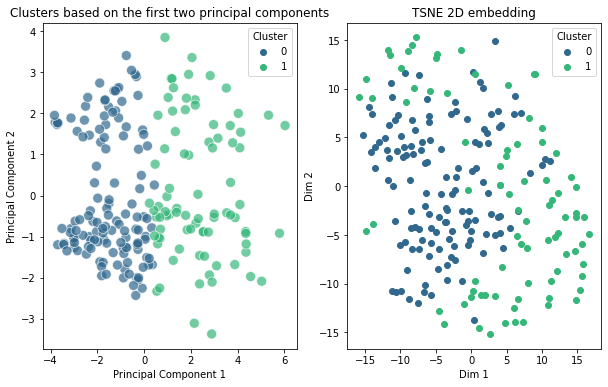

In [212]:
skills_embedded_programming2 = TSNE(n_components=2,init='random', perplexity=20).fit_transform(np.array(skills_df2, dtype='float'))

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
sns.scatterplot(data=skills_reduced_programming2, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters based on the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')


plt.subplot(1,2,2)


for n_clus in range(n_clusters):
    idx = np.where(skills_reduced_programming2['Cluster'].values==n_clus)[0]
    plt.scatter(skills_embedded_programming2[idx,0],skills_embedded_programming2[idx,1], color=sns.color_palette('viridis', n_clusters)[n_clus])


plt.title('TSNE 2D embedding')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend([str(i) for i in range(n_clusters)],title='Cluster')
plt.savefig('cluster_programming2.4.png', dpi=300)
plt.show()

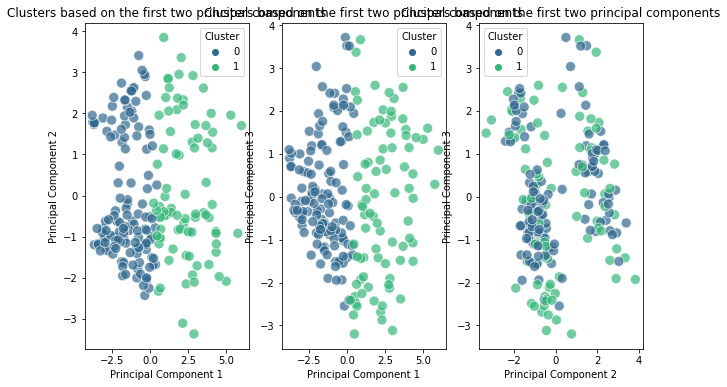

In [213]:
plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)

sns.scatterplot(data=skills_reduced_programming2, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters based on the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')

plt.subplot(1,3,2)
sns.scatterplot(data=skills_reduced_programming2, x='PC1', y='PC3', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters based on the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.legend(title='Cluster')

plt.subplot(1,3,3)
sns.scatterplot(data=skills_reduced_programming2, x='PC2', y='PC3', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters based on the first two principal components')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.legend(title='Cluster')
plt.show()

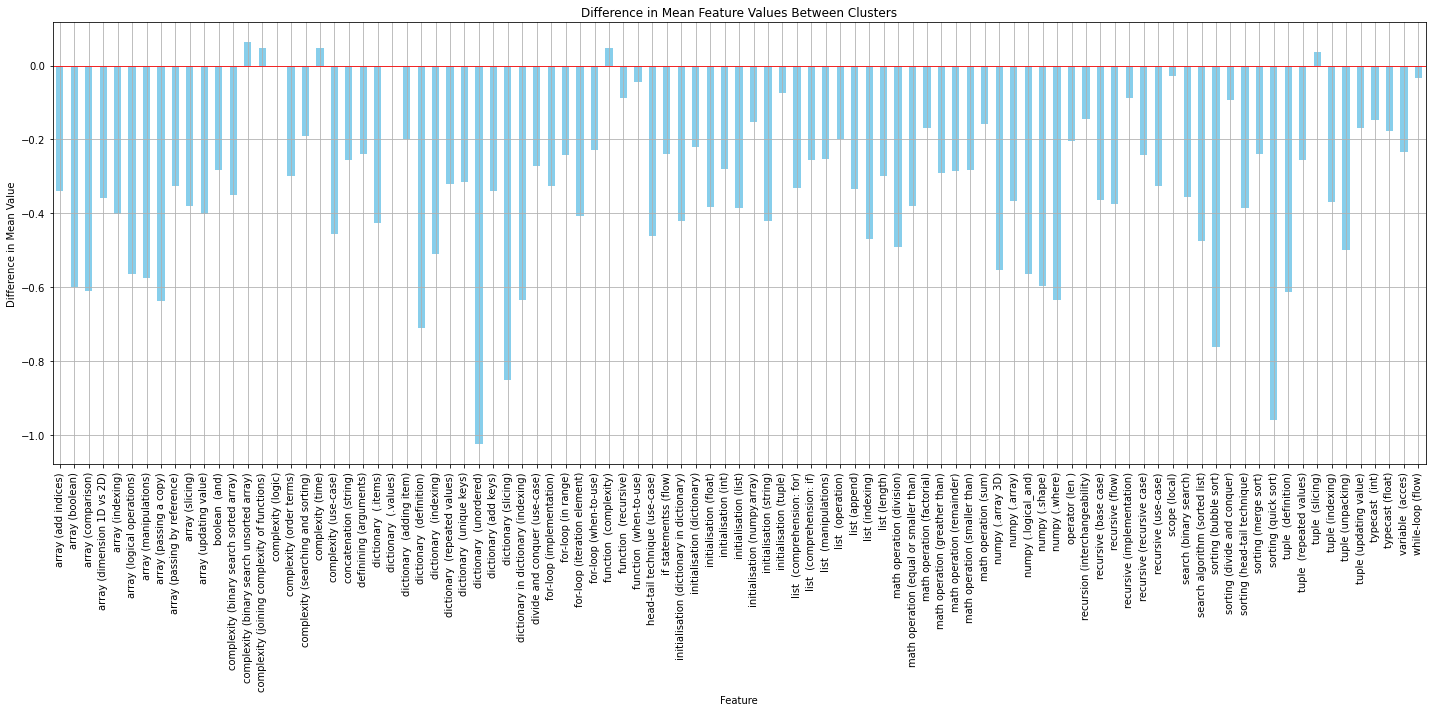

In [214]:
skills_df2['Cluster'] = kmeans2.labels_

cluster_means = skills_df2.groupby('Cluster').mean()

cluster_diff = cluster_means.diff().iloc[-1]

plt.figure(figsize=(20, 10)) 
cluster_diff.plot(kind='bar', color='skyblue')  
plt.title('Difference in Mean Feature Values Between Clusters')
plt.xlabel('Feature')
plt.ylabel('Difference in Mean Value')
plt.axhline(0, color='red', linewidth=0.8)
plt.grid(True)
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.savefig('mean_clusters2.4.png', dpi=300, bbox_inches='tight')  
plt.show()

In [215]:
def get_top_n_features(component, feature_names, n=3):
    abs_component = np.abs(component)
    top_n_indices = abs_component.argsort()[-n:][::-1]
    top_n_features = [(feature_names[i], component[i]) for i in top_n_indices]
    return top_n_features

feature_names = skills_df2.columns

top_features_pc1 = get_top_n_features(pca2_components[0], feature_names, n=5)
top_features_pc2 = get_top_n_features(pca2_components[1], feature_names, n=5)
top_features_pc3 = get_top_n_features(pca2_components[2], feature_names, n=5)

print("Top features for PC1:", top_features_pc1)
print("Top features for PC2:", top_features_pc2)
print("Top features for PC3:", top_features_pc3)





Top features for PC1: [('dictionary  (unordered)', -0.22837284623973247), ('sorting (quick sort)', -0.20567061288164495), ('dictionary  (definition)', -0.18253401376549566), ('array (passing a copy)', -0.17657142981662965), ('numpy (.logical_and)', -0.17551770592341515)]
Top features for PC2: [('complexity (joining complexity of functions)', 0.5440630380368514), ('complexity (time)', 0.5440630380368514), ('function  (when-to-use)', 0.24214214434502299), ('while-loop (flow)', 0.20921071227010596), ('dictionary  (unordered)', -0.18648074322530458)]
Top features for PC3: [('array (logical operations)', -0.4493413982093093), ('numpy (.logical_and)', -0.4493413982093087), ('dictionary (slicing)', 0.2848616144470503), ('dictionary  (unordered)', 0.24355868837202407), ('complexity (use-case)', -0.24067052589536264)]


Features for Principal Component 2: ('complexity (joining complexity of functions)', 'complexity (time)', 'function  (when-to-use)', 'while-loop (flow)', 'dictionary  (unordered)')
Weights for Principal Component 2: (0.5440630380368514, 0.5440630380368514, 0.24214214434502299, 0.20921071227010596, -0.18648074322530458)


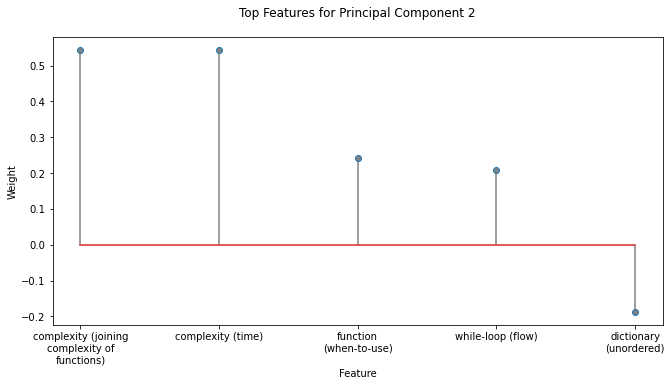

In [216]:
def plot_top_features(top_features, pc_name):

    def split_long_name(name, max_length=20):
        words = name.split()
        new_name = ''
        current_line = ''
        for word in words:
            if len(current_line) + len(word) + 1 > max_length:
                new_name += current_line + '\n'
                current_line = word
            else:
                if current_line:
                    current_line += ' '
                current_line += word
        new_name += current_line
        return new_name

    features, weights = zip(*top_features)
    print(f"Features for {pc_name}: {features}")
    print(f"Weights for {pc_name}: {weights}")
    
   
    split_features = [split_long_name(f) for f in features]
    
    indices = np.arange(len(weights)) 

    plt.figure(figsize=(10, 6)) 
    

    markerline, stemlines, baseline = plt.stem(indices, weights, use_line_collection=True)
    plt.setp(markerline, 'markerfacecolor', 'gray')
    plt.setp(stemlines, 'color', 'gray')
    
    plt.xticks(indices, split_features)  
    
    plt.title(f'Top Features for {pc_name}', pad=20)  
    plt.ylabel('Weight')
    plt.xlabel('Feature')

    plt.tight_layout(pad=3.0)
    
    
    plt.savefig('top_features_programming2_component_2.png', dpi=300)
    plt.show()

plot_top_features(top_features_pc2, 'Principal Component 2')


C:\Users\31611\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


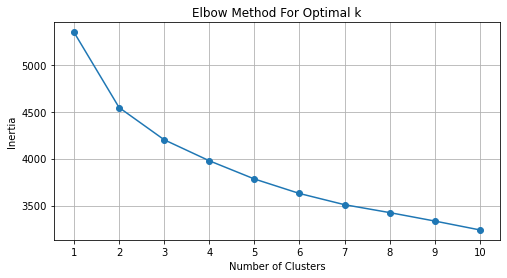

In [217]:
pca = PCA(n_components=15)
skills_reduced = pca.fit_transform(skills_df2)


range_clusters = range(1, 11)  
inertias = []

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(skills_reduced)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(8, 4))
plt.plot(range_clusters, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

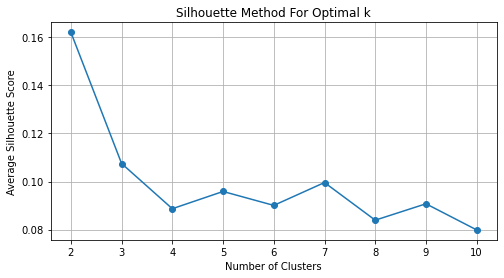

In [218]:
range_clusters = range(2, 11)  
silhouette_scores = []

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(skills_reduced)


    silhouette_avg = silhouette_score(skills_reduced, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)


plt.figure(figsize=(8, 4))
plt.plot(range_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.xticks(range_clusters)
plt.grid(True)
plt.savefig('silhouette_programming2.4.png', dpi=300)
plt.show()


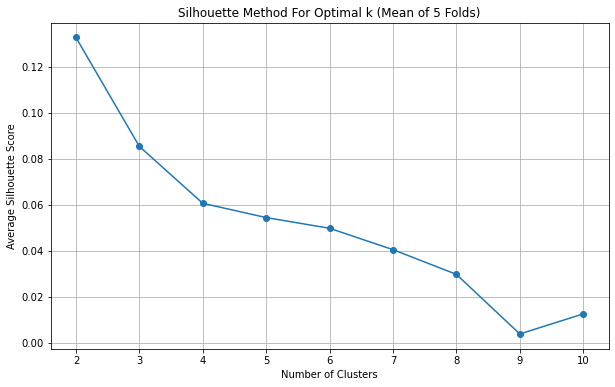

In [219]:
range_clusters = range(2, 11)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=None)

mean_silhouette_scores = []

for n_clusters in range_clusters:
    silhouette_scores = []
    
    for train, test in kf.split(skills_df2):
        pca_traintest = PCA(n_components=28)
        
        skills_df_train = skills_df2.iloc[train, :]
        skills_df_test = skills_df2.iloc[test, :]
        skills_reduced_train = pca_traintest.fit_transform(skills_df_train)
        skills_reduced_test = pca_traintest.transform(skills_df_test)

        kmeans_traintest = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans_traintest.fit(skills_reduced_train)

        cluster_labels = kmeans_traintest.predict(skills_reduced_test)
        
    
        score = silhouette_score(skills_reduced_test, cluster_labels)
        silhouette_scores.append(score)
    

    mean_silhouette_scores.append(sum(silhouette_scores) / len(silhouette_scores))


plt.figure(figsize=(10, 6))
plt.plot(range_clusters, mean_silhouette_scores, marker='o')
plt.title('Silhouette Method For Optimal k (Mean of 5 Folds)')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.xticks(range_clusters)
plt.grid(True)
plt.savefig('silhouette_programming2.4.png', dpi=300)
plt.show()

In [220]:
k=5
kf = model_selection.KFold(n_splits=k, shuffle=True, random_state=None)

for train, test in kf.split(skills_df2):

    pca_traintest = PCA(n_components=28)
    
    skills_df_train = skills_df2.iloc[train,:]
    skills_df_test = skills_df2.iloc[test,:]
    skills_reduced_train = pca_traintest.fit_transform(skills_df_train)
    skills_reduced_test = pca_traintest.transform(skills_df_test)



    skills_reduced_train_df = pd.DataFrame(skills_reduced_train, columns=[f'PC{i+1}' for i in range(28)], index=skills_df_train.index)
    kmeans_traintest = KMeans(n_clusters=2, random_state=0)
    kmeans_traintest.fit(skills_reduced_train_df)
    print(kmeans_traintest.predict(skills_reduced_test))
    print()


    skills_reduced_train_df['Cluster'] = kmeans_traintest.labels_

[1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1
 1 1 1 1 1 1 1]

[1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 0 1 1]

[0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0
 0 0 1 0 1 0]

[1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0
 1 0 1 1 1 1]

[1 0 0 1 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1
 0 0 0 0 1 0]



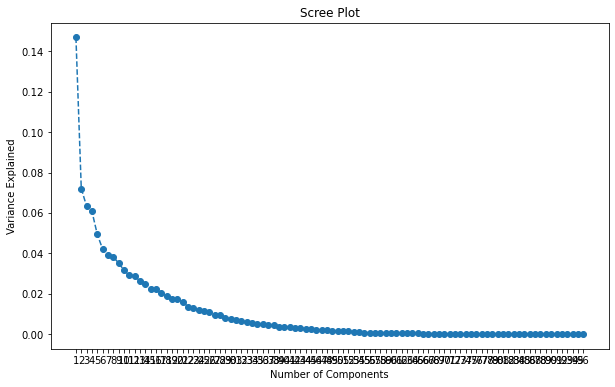

In [221]:
pca = PCA()
pca.fit(skills_df2)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

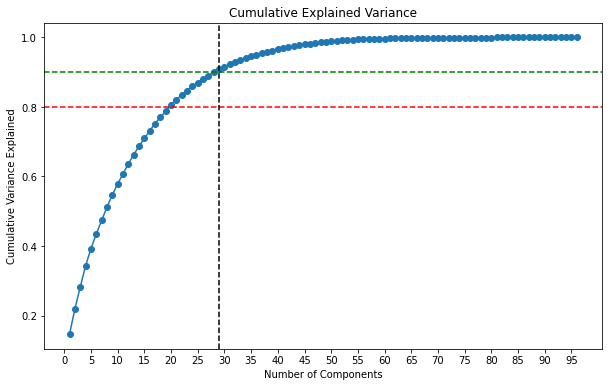

In [222]:
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.axhline(y=0.8, color='r', linestyle='--') 
plt.axhline(y=0.9, color='g', linestyle='--')  

n_comp = np.where(cumulative_explained_variance>0.9)[0][0]+1
plt.axvline(x=n_comp, color='k', linestyle='--')  

plt.xticks(range(0, len(pca.explained_variance_ratio_) + 1,5))
plt.savefig('cev_programming2.4.png', dpi=300)
plt.show()

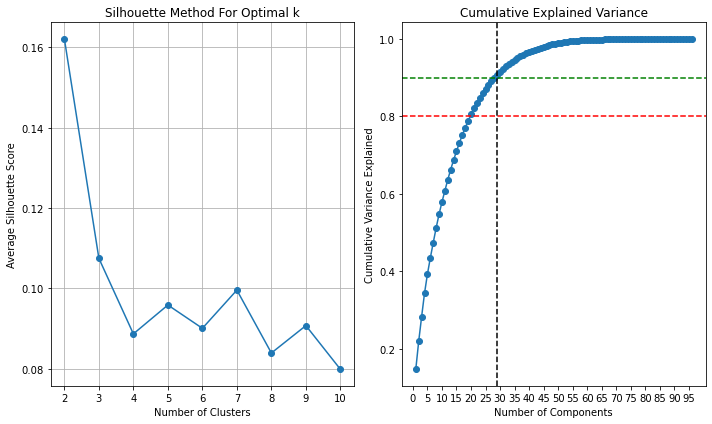

In [223]:
range_clusters = range(2, 11)  
silhouette_scores = []

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(skills_reduced)
    silhouette_avg = silhouette_score(skills_reduced, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)


cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))


ax1.plot(range_clusters, silhouette_scores, marker='o')
ax1.set_title('Silhouette Method For Optimal k')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Average Silhouette Score')
ax1.set_xticks(range_clusters)
ax1.grid(True)


ax2.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
ax2.set_title('Cumulative Explained Variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.axhline(y=0.8, color='r', linestyle='--')  
ax2.axhline(y=0.9, color='g', linestyle='--')  
n_comp = np.where(cumulative_explained_variance > 0.9)[0][0] + 1
ax2.axvline(x=n_comp, color='k', linestyle='--')  
ax2.set_xticks(range(0, len(pca.explained_variance_ratio_) + 1, 5))

plt.tight_layout()
plt.savefig('combined_plot2.png', dpi=300)
plt.show()

In [224]:
df1 = pd.DataFrame(skills_reduced_programming1)
df1.index.name = 'id'
df2 = pd.DataFrame(skills_reduced_programming2)
df2.index.name = 'id'


common_ids = df1.index.intersection(df2.index)

df1_filtered = df1.loc[common_ids]
df2_filtered = df2.loc[common_ids]


print("Filtered skills_reduced_programming1:")
print(df1_filtered)

print("Filtered skills_reduced_programming2:")
print(df2_filtered)

Filtered skills_reduced_programming1:
          PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
id                                                                          
2   -1.235201  1.149404  0.518480 -1.814694  0.728832 -0.010244  1.485842   
3   -0.647821  0.135124  2.828531 -0.084717 -0.520548  1.528049 -0.571658   
5   -2.377471 -0.414682 -0.868716  0.725194  1.100801 -0.264332 -0.822611   
6   -2.070954  0.001165 -0.851492  0.659451  1.153949 -1.489022  1.097417   
8   -2.158343  0.292872 -0.997731  1.712597  0.436425  0.446139 -0.772806   
..        ...       ...       ...       ...       ...       ...       ...   
238 -2.138290 -0.893976 -0.749334 -0.721614 -0.017504 -0.669611  1.578649   
239 -1.682027 -2.590405  1.343081 -0.111318 -0.167838  0.673137  0.299991   
241 -2.213667 -0.707564 -0.844248 -0.408699 -1.396914  0.085562 -0.104283   
242  1.709403 -1.101901 -2.029725 -0.728469 -0.912660 -1.314947  1.029758   
244 -2.023796 -0.832996 -0.677440 -0.5

In [225]:
print("Columns in first dataset:", skills_reduced_programming1.columns)
print("Columns in second dataset:", skills_reduced_programming2.columns)

Columns in first dataset: Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'Cluster'],
      dtype='object')
Columns in second dataset: Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28',
       'Cluster'],
      dtype='object')


Cluster_time2   0   1
Cluster_time1        
0              50  31
1              62  49


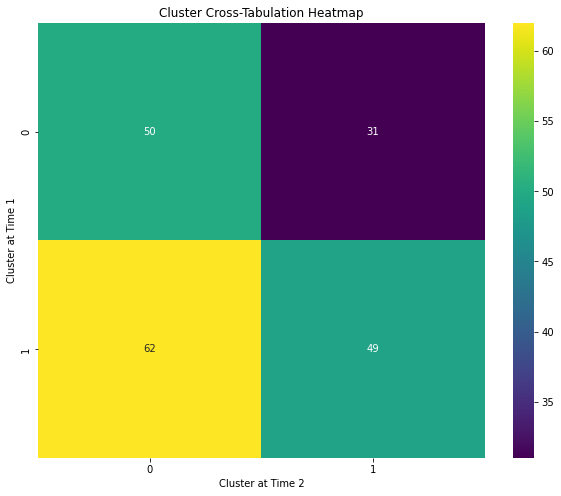

In [226]:
merged_clusters = pd.merge(df1_filtered[['Cluster']], df2_filtered[['Cluster']], left_index=True, right_index=True, suffixes=('_time1', '_time2'))


cluster_crosstab = pd.crosstab(merged_clusters['Cluster_time1'], merged_clusters['Cluster_time2'])
print(cluster_crosstab)
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_crosstab, annot=True, fmt="d", cmap="viridis")
plt.title('Cluster Cross-Tabulation Heatmap')
plt.xlabel('Cluster at Time 2')
plt.ylabel('Cluster at Time 1')
plt.savefig('consistency_programming2.4.png', dpi=300)

plt.show()


In [227]:


ari_score = adjusted_rand_score(df1_filtered['Cluster'], df2_filtered['Cluster'])
print(f"Adjusted Rand Index: {ari_score:.3f}")

Adjusted Rand Index: -0.005


In [228]:
binary_clusters_time1 = pd.get_dummies(df1_filtered['Cluster'])
binary_clusters_time2 = pd.get_dummies(df2_filtered['Cluster'])


jaccard_scores = []
for col1 in binary_clusters_time1:
    for col2 in binary_clusters_time2:
        score = jaccard_score(binary_clusters_time1[col1], binary_clusters_time2[col2])
        jaccard_scores.append(score)

average_jaccard_score = sum(jaccard_scores) / len(jaccard_scores)
print(f"Average Jaccard Score: {average_jaccard_score:.3f}")


Average Jaccard Score: 0.330


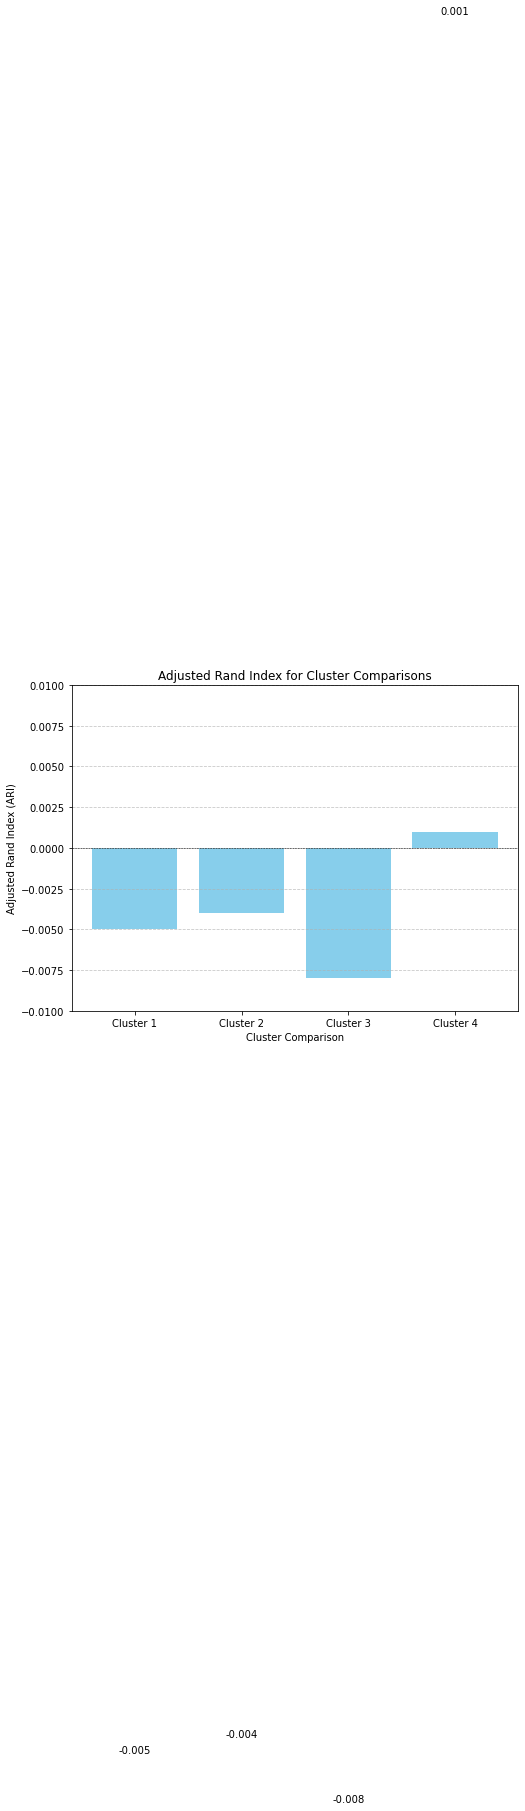

In [229]:
clusters = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
ari_scores = [-0.005, -0.004, -0.008, 0.001]


plt.figure(figsize=(8, 6))
bars = plt.bar(clusters, ari_scores, color='skyblue')

for bar, score in zip(bars, ari_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 0.05 if score >= 0 else bar.get_height() - 0.05,
             f"{score:.3f}",
             ha='center', va='bottom' if score >= 0 else 'top')

plt.title('Adjusted Rand Index for Cluster Comparisons')
plt.xlabel('Cluster Comparison')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.ylim(-0.01, 0.01) 
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('ari.png', dpi=300)
plt.show()